In [22]:
import pandas as pd
from pathlib import Path
import json
from pprint import pprint
import math
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

DATA_DIR = Path("data/benchmarking")

In [23]:
def get_in_road_percentage(steps_df: pd.DataFrame) -> float:
    ret = steps_df["out_of_road"].value_counts(normalize=True).at[False]
    return ret

In [24]:
def get_n_crashes(steps_df: pd.DataFrame) -> int:
    """Count number of crash episodes to not count same crash multiple times"""
    try:
        # count number of times "crash" becomes True for some time
        n_crashes = steps_df["crash"].diff().value_counts().at[True]

        # need to divide by 2 beacouse diff counts twice
        n_crashes /= 2

        # just in case crash is last episode and we have 3.5 crash episodes make it 4
        n_crashes = math.ceil(n_crashes)
    except KeyError:
        n_crashes = 0

    return n_crashes

In [25]:
def process_steps(steps_infos: list) -> dict:
    """Accepts a list of steps and returns a dict of interesting data"""

    steps_df = pd.DataFrame(steps_infos)
    steps_data = {}
    last_step = steps_df.iloc[-1]

    steps_data = {
        "termination.arrive_dest": last_step["arrive_dest"],
        "termination.timeout": last_step["max_step"],
        "route_completion": last_step["route_completion"],
        "seed": last_step["env_seed"],
        "in_road_percentage": get_in_road_percentage(steps_df),
        "n_crashes": get_n_crashes(steps_df),
    }

    return steps_data

In [26]:
def get_scenarios_df(dir: Path):
    paths = list(dir.glob("*/*.json"))

    scenarios = []
    for file_path in tqdm(paths):

        with open(file_path, "r") as f:
            scenario_data = json.load(f)

        dir = file_path.__str__().split("/")[-2]
        _, dr, _, dt = dir.split("_")
        scenario_data["decision_repeat"] = int(dr)
        scenario_data["dt"] = float(dt)

        steps_infos = scenario_data.pop("steps_infos")
        scenario_data.update(process_steps(steps_infos))
        scenarios.append(scenario_data)
    return pd.DataFrame(scenarios)

In [27]:
df = get_scenarios_df(DATA_DIR)

100%|██████████| 1200/1200 [00:03<00:00, 357.34it/s]


In [28]:
df = df.set_index(
    [
        "dt",
        "decision_repeat",
        "seed",
    ],
    verify_integrity=True,
)

df = df.sort_index()

In [29]:
df["n_crashes"].sort_values(ascending=False).head(20)

dt    decision_repeat  seed
0.02  5                39      347
0.03  10               29      153
0.02  15               42      116
0.04  10               41      110
0.02  20               73      106
      15               73      102
0.03  15               55       92
      10               12       91
      20               72       89
      15               73       73
0.04  20               21       64
      10               15       61
0.03  10               42       51
0.04  20               63       48
0.02  5                7        47
0.03  20               92       42
0.04  20               61       42
                       90       39
0.03  20               20       33
0.02  20               66       27
Name: n_crashes, dtype: int64

In [30]:
# ! Problem changing the values here in the analysis can change % error

df["driving_score"] = (
    df["route_completion"] * df["in_road_percentage"] * (0.9) ** df["n_crashes"]
)

In [31]:
oracle_ds = df.xs((0.02, 5))["driving_score"]
oracle_ds

seed
0     0.993165
1     0.184633
2     0.993426
3     0.989208
4     0.803575
        ...   
95    0.994201
96    0.992842
97    0.586869
98    0.892667
99    0.989554
Name: driving_score, Length: 100, dtype: float64

In [32]:
df["driving_score_error"] = (df["driving_score"] - oracle_ds).abs()
df

start_ts  initialized_ts  scenario_done_ts  \
dt   decision_repeat seed                                                   
0.02 5               0       323.746797      324.153472        354.664337   
                     1       392.692564      392.879098        444.943443   
                     2       466.414890      466.616739        494.656436   
                     3       532.356742      532.534259        550.221780   
                     4       573.403475      573.583460        597.535358   
...                                 ...             ...               ...   
0.04 20              95    13687.748237    13687.930277      13689.314883   
                     96    13757.597595    13757.761152      13768.529535   
                     97    13808.345767    13808.637842      13809.238240   
                     98    13896.393384    13896.650355      13902.209748   
                     99    13949.578799    13949.712110      13952.818566   

                           init_time  scenario_time  total_time  \
dt   decision_repeat seed                                         
0.02 5               0      0.406676      30.510864   30.917540   
                     1      0.186534      52.064345   52.250879   
                     2      0.201848      28.039698   28.241546   
                     3      0.177516      17.687521   17.865038   
                     4      0.179985      23.951898   24.131883   
...                              ...            ...         ...   
0.04 20              95     0.182040       1.384606    1.566646   
                     96     0.163557      10.768383   10.931941   
                     97     0.292076       0.600398    0.892473   
                     98     0.256971       5.559393    5.816364   
                     99     0.133310       3.106456    3.239767   

                                                                    map_data  \
dt   decision_repeat seed                                                      
0.02 5               0     [{'id': 'I', 'pre_block_socket_index': None}, ...   
                     1     [{'id': 'I', 'pre_block_socket_index': None}, ...   
                     2     [{'id': 'I', 'pre_block_socket_index': None}, ...   
                     3     [{'id': 'I', 'pre_block_socket_index': None}, ...   
                     4     [{'id': 'I', 'pre_block_socket_index': None}, ...   
...                                                                      ...   
0.04 20              95    [{'id': 'I', 'pre_block_socket_index': None}, ...   
                     96    [{'id': 'I', 'pre_block_socket_index': None}, ...   
                     97    [{'id': 'I', 'pre_block_socket_index': None}, ...   
                     98    [{'id': 'I', 'pre_block_socket_index': None}, ...   
                     99    [{'id': 'I', 'pre_block_socket_index': None}, ...   

                           max_steps  termination.arrive_dest  \
dt   decision_repeat seed                                       
0.02 5               0          3364                     True   
                     1          1892                    False   
                     2          3574                     True   
                     3          2092                     True   
                     4          2815                     True   
...                              ...                      ...   
0.04 20              95          423                    False   
                     96          330                    False   
                     97          352                    False   
                     98          342                     True   
                     99          251                    False   

                           termination.timeout  route_completion  \
dt   decision_repeat seed                                          
0.02 5               0                   False          0.993165   
                     1                    True          0.347420  

In [33]:
palette = sns.color_palette("hls", 3)
x_ticks = df.index.get_level_values("decision_repeat").unique().to_list()
x_ticks

[5, 10, 15, 20]

## Bloxplots


Text(0.5, 0, 'Decision repeat')

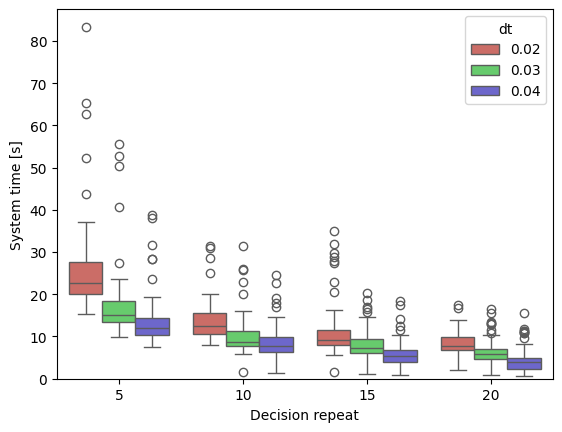

In [80]:
ax = sns.boxplot(df, x="decision_repeat", y="total_time", hue="dt", palette=palette)
ax.set_ylim(0)
ax.set_ylabel("System time [s]")
ax.set_xlabel("Decision repeat")
# ax.set_xticks(x_ticks)

## Original plotting


In [35]:
agg = df.select_dtypes("number").groupby(by=["dt", "decision_repeat"]).mean()
agg

start_ts  initialized_ts  scenario_done_ts  \
dt   decision_repeat                                                   
0.02 5                 3306.236850     3306.428120       3331.414196   
     10                3331.688450     3331.877859       3345.220106   
     15                3345.487210     3345.676556       3356.272830   
     20                3356.537141     3356.726927       3364.845517   
0.03 5                10154.008581    10154.197949      10171.134809   
     10               10185.209884    10185.397257      10195.190454   
     15               10204.389997    10204.578981      10212.428546   
     20               10218.812211    10219.000946      10224.919812   
0.04 5                10171.445992    10171.634070      10184.900328   
     10               10195.499038    10195.687781      10204.083296   
     15               10212.736637    10212.925996      10218.506985   
     20               10225.225509    10225.414834      10229.471472   

                      init_time  scenario_time  total_time  max_steps  \
dt   decision_repeat                                                    
0.02 5                 0.191270      24.986076   25.177346    2738.68   
     10                0.189409      13.342247   13.531656    1369.32   
     15                0.189346      10.596274   10.785621     912.86   
     20                0.189785       8.118590    8.308376     684.65   
0.03 5                 0.189368      16.936860   17.126228    1825.79   
     10                0.187373       9.793197    9.980570     912.86   
     15                0.188984       7.849565    8.038549     608.62   
     20                0.188735       5.918866    6.107601     456.45   
0.04 5                 0.188077      13.266258   13.454336    1369.32   
     10                0.188743       8.395515    8.584258     684.65   
     15                0.189358       5.580989    5.770348     456.45   
     20                0.189325       4.056638    4.245963     342.37   

                      route_completion  in_road_percentage  n_crashes  \
dt   decision_repeat                                                    
0.02 5                        0.970994            1.000000       5.24   
     10                       0.971221            0.999971       1.37   
     15                       0.951197            0.999722       3.80   
     20                       0.978979            0.999782       3.27   
0.03 5                        0.972420            0.999956       1.80   
     10                       0.959413            0.999722       4.44   
     15                       0.914904            0.998503       4.78   
     20                       0.848883            0.995686       5.21   
0.04 5                        0.964109            1.000000       1.46   
     10                       0.943235            0.999411       4.91   
     15                       0.851819            0.995072       3.49   
     20                       0.655548            0.989029       4.81   

                      driving_score  driving_score_error  
dt   decision_repeat                                      
0.02 5                     0.857783             0.000000  
     10                    0.865399             0.124403  
     15                    0.811568             0.147874  
     20                    0.802382             0.195380  
0.03 5                     0.853729             0.111684  
     10                    0.812663             0.189124  
     15                    0.681513             0.266308  
     20                    0.590645             0.355984  
0.04 5                     0.847029             0.143944  
     10                    0.693466             0.260468  
     15                    0.607593             0.331142  
     20                    0.454277             0.460733

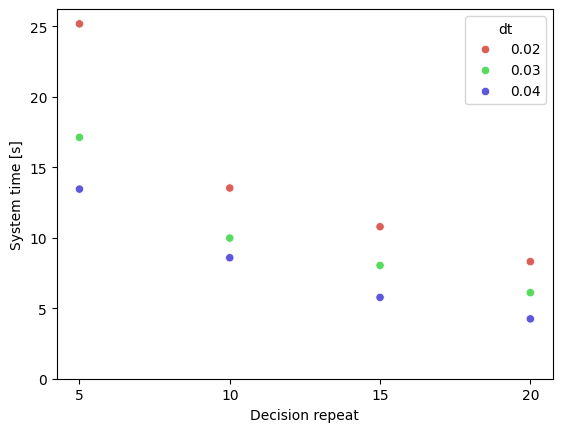

In [36]:
ax = sns.scatterplot(
    agg, x="decision_repeat", y="total_time", hue="dt", palette=palette
)
ax.set_ylim(0)
ax.set_ylabel("System time [s]")
ax.set_xlabel("Decision repeat")
ax.set_xticks(x_ticks)

Text(0, 0.5, 'Driving Score Error')

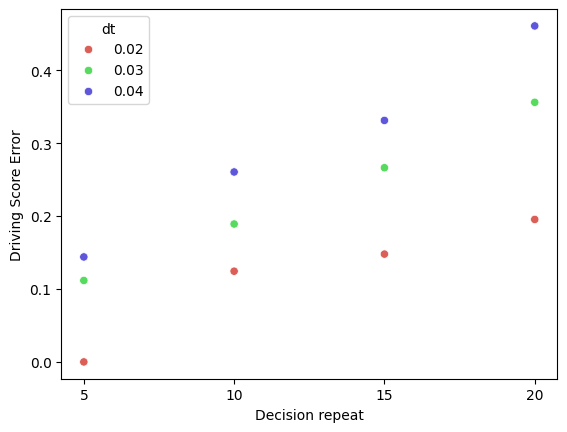

In [37]:
ax = sns.scatterplot(
    agg, x="decision_repeat", y="driving_score_error", hue="dt", palette=palette
)

ax.set_xlabel("Decision repeat")
ax.set_xticks(x_ticks)

ax.set_ylabel("Driving Score Error")

## 3D Plots


In [58]:
import numpy as np

line = agg.loc[0.02, ["driving_score_error", "total_time"]].reset_index().to_numpy().T
xs, ys, zs = line
xs

array([ 5., 10., 15., 20.])

     dt  decision_repeat  driving_score_error  total_time
0  0.02                5             0.000000   25.177346
1  0.02               10             0.124403   13.531656
2  0.02               15             0.147874   10.785621
3  0.02               20             0.195380    8.308376
     dt  decision_repeat  driving_score_error  total_time
0  0.03                5             0.111684   17.126228
1  0.03               10             0.189124    9.980570
2  0.03               15             0.266308    8.038549
3  0.03               20             0.355984    6.107601
     dt  decision_repeat  driving_score_error  total_time
0  0.04                5             0.143944   13.454336
1  0.04               10             0.260468    8.584258
2  0.04               15             0.331142    5.770348
3  0.04               20             0.460733    4.245963


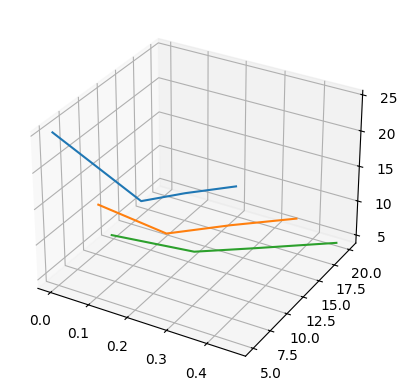

In [82]:
ax = plt.figure().add_subplot(projection="3d")


for dt, batch in agg[["driving_score_error", "total_time"]].groupby("dt"):
    batch = batch.reset_index()
    print(batch)
    ys = batch["decision_repeat"].to_numpy()
    zs = batch["total_time"].to_numpy()
    xs = batch["driving_score_error"].to_numpy()
    ax.plot3D(xs, ys, zs)